## Power Spectrum based on OLR

### Import package

In [14]:
import numpy as np;
import netCDF4 as nc;

from SpaceTimeReconstruct import SpaceTimeFilter, DispersionParams, BandpassParams
from scipy.ndimage import convolve1d;
from matplotlib import pyplot as plt;

### Load file

In [15]:
fpath = "/work/DATA/Satellite/OLR/olr_anomaly.nc";

with nc.Dataset( fpath, "r" ) as ds:
    dims = {
        key: ds[key][:]
        for key in ds.dimensions.keys()
    };
    
    lat_lim = np.where( ( dims["lat"] >= -5.0 ) & ( dims["lat"] <= 5.0 ) )[0];
    dims["lat"]  = dims["lat"][lat_lim];
    dims["time"] = dims["time"][:1000];
    
    olr = ds["olr"][:1000, lat_lim, :];

### Processing data

#### Form symmetric data

In [16]:
olr -= olr.mean( axis=(0, 2), keepdims=True )

sym = ( olr + np.flip( olr, axis=1 ) ) / 2;

### Wavenumber and Frequency

In [17]:
wn = np.fft.fftfreq( dims["lon"].size, d=1/dims["lon"].size )
fr = np.fft.fftfreq( dims["time"].size, d=1 )

wnm, frm = np.meshgrid( wn, fr ) # meshgrid of wavenumber and frequency

(1.0, 100.0)

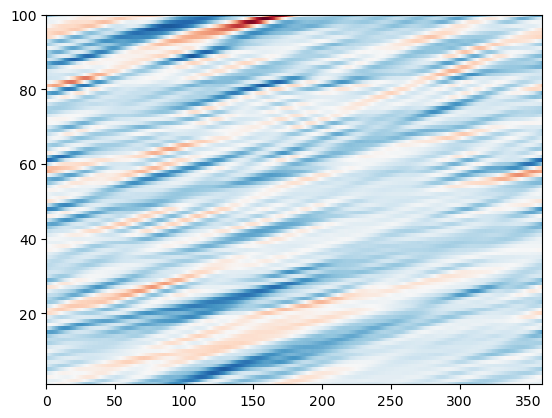

In [18]:
filt = SpaceTimeFilter(
    dispersion=DispersionParams(n_planetary_wave=576, rlat=0.0, equivalent_depth=(8, 90), s_min=-288, s_max=287),
    bandpass=BandpassParams(k_range=(1, 14), f_range=(1/30, 1/2.5), nan_to_inf=True),
)

kel_recon, mask = filt.compute(
    data=sym,
    fr_grid=frm,
    wn_grid=wnm,
    wave_type="Kelvin",
    return_mask=True,)

plt.pcolormesh( dims["lon"], np.linspace( 1, 1000, 1000 ), kel_recon, cmap="RdBu" )
plt.ylim( 1, 100 )